In [1]:
import glob
from scipy.io import loadmat
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

In [2]:
df = pd.read_csv('0hp_all_faults.csv')

In [3]:
import numpy as np
import pandas as pd
from scipy.signal import cwt, morlet
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len = 784
stride = 300

X = []
Y = []

widths = np.arange(1, 64)
wavelet = morlet

for k in df['fault'].unique():
    df_temp_2 = df[df['fault'] == k]

    for i in np.arange(0, len(df_temp_2) - (win_len), stride):
        temp = df_temp_2.iloc[i:i + win_len, :-1].values
        temp = np.sum(temp, axis=1)
        # Przeprowadź CWT na każdej próbce
        cwt_data = cwt(temp, wavelet, widths)
        
        # Zmień kształt danych (pozostaw dwuwymiarowe)
        cwt_data = np.abs(cwt_data)

        X.append(cwt_data)
        Y.append(df_temp_2.iloc[i + win_len, -1])

X = np.array(X)
Y = np.array(Y)

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

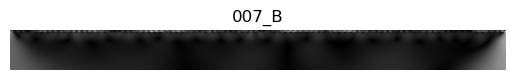

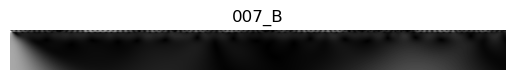

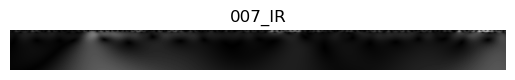

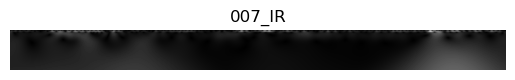

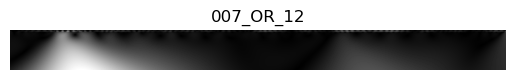

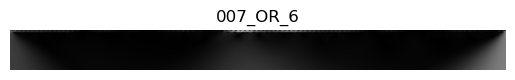

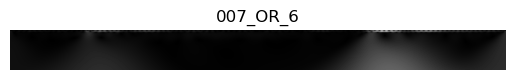

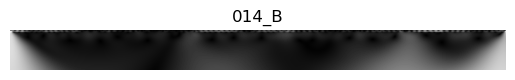

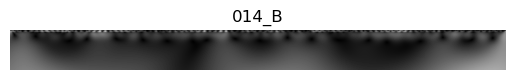

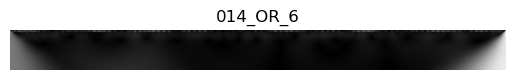

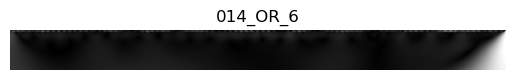

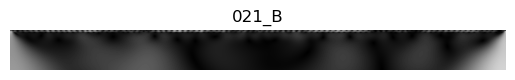

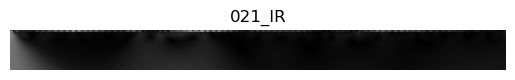

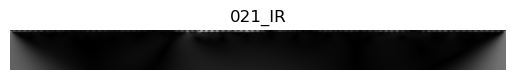

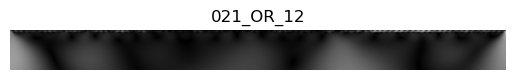

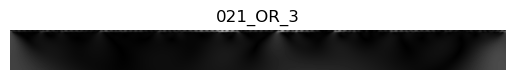

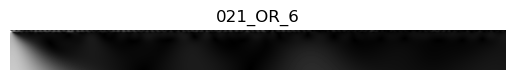

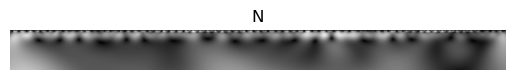

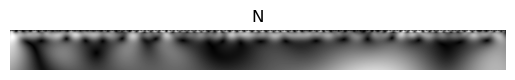

In [4]:
from matplotlib.pyplot import imread


for idx in range(0,9244,500):
    img=X[idx]

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [6]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(X.shape[1],X.shape[2],1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(16, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 59, 780, 6)        156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 390, 6)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 386, 16)       2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 193, 16)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 37056)             0         
                                                                 
 dense (Dense)               (None, 120)               4

In [8]:
# Definiujesz wczesne zatrzymywanie
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trenujesz model z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodajesz wczesne zatrzymywanie do listy callbacks
)

Epoch 1/80
17/17 [==============================] - 88s 5s/step - loss: 2.2029 - accuracy: 0.2539 - val_loss: 1.6358 - val_accuracy: 0.5534
Epoch 2/80
17/17 [==============================] - 83s 5s/step - loss: 1.2487 - accuracy: 0.6245 - val_loss: 0.9270 - val_accuracy: 0.6975
Epoch 3/80
17/17 [==============================] - 85s 5s/step - loss: 0.7829 - accuracy: 0.7328 - val_loss: 0.7014 - val_accuracy: 0.7441
Epoch 4/80
17/17 [==============================] - 87s 5s/step - loss: 0.5699 - accuracy: 0.7960 - val_loss: 0.5586 - val_accuracy: 0.8100
Epoch 5/80
17/17 [==============================] - 80s 5s/step - loss: 0.4624 - accuracy: 0.8381 - val_loss: 0.5480 - val_accuracy: 0.8071
Epoch 6/80
17/17 [==============================] - 81s 5s/step - loss: 0.3897 - accuracy: 0.8690 - val_loss: 0.3896 - val_accuracy: 0.8720
Epoch 7/80
17/17 [==============================] - 81s 5s/step - loss: 0.3076 - accuracy: 0.8965 - val_loss: 0.3204 - val_accuracy: 0.8879
Epoch 8/80
17/17 [==

87/87 [==============================] - 9s 99ms/step


Text(95.72222222222221, 0.5, 'Poprawna klasa')

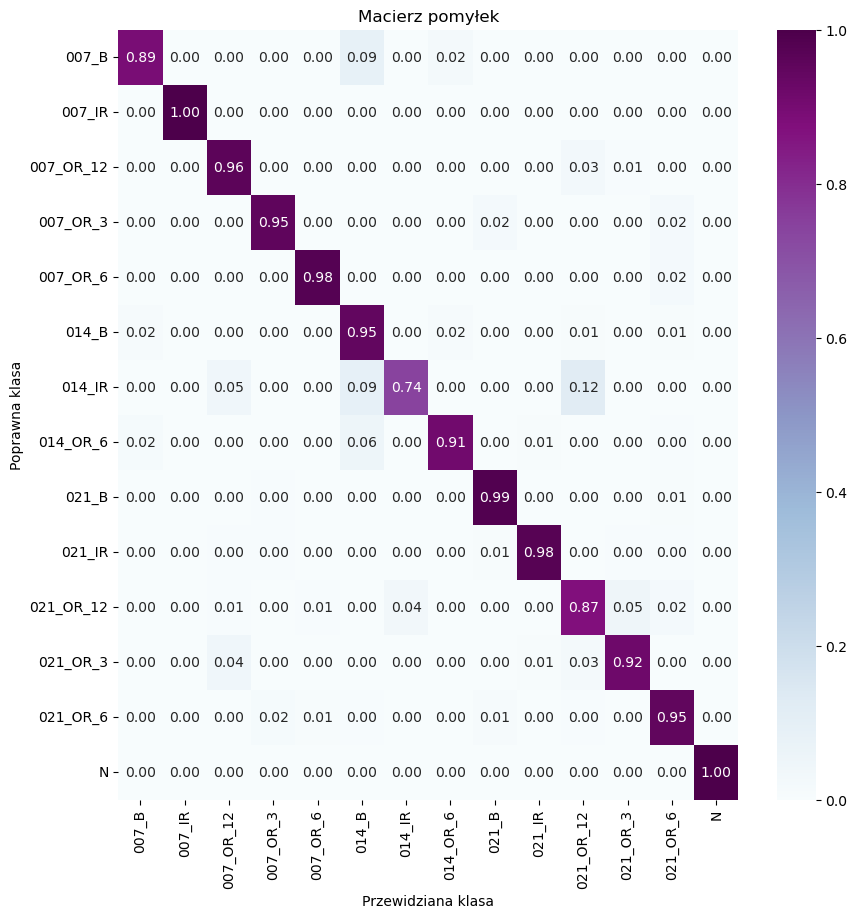

In [9]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

In [10]:
from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, Y_pred)
print(score)

0.9491708723864456


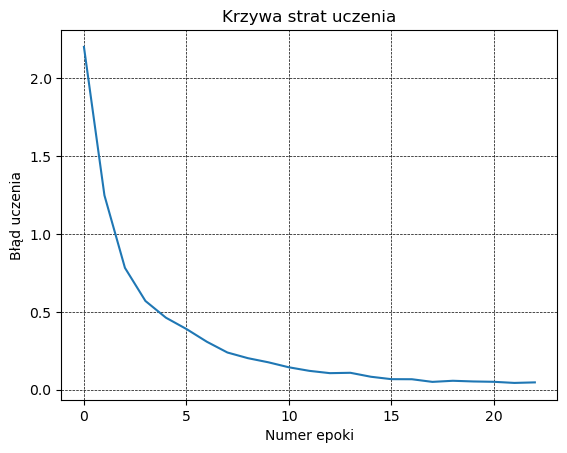

In [11]:
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

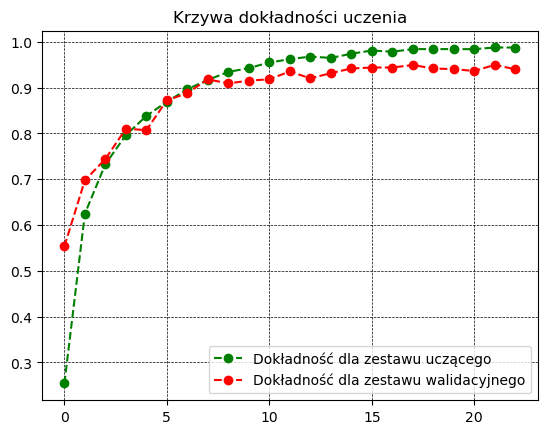

In [12]:
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

203/203 [==============================] - 21s 101ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6472 samples in 0.024s...
[t-SNE] Computed neighbors for 6472 samples in 1.259s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6472
[t-SNE] Computed conditional probabilities for sample 2000 / 6472
[t-SNE] Computed conditional probabilities for sample 3000 / 6472
[t-SNE] Computed conditional probabilities for sample 4000 / 6472
[t-SNE] Computed conditional probabilities for sample 5000 / 6472
[t-SNE] Computed conditional probabilities for sample 6000 / 6472
[t-SNE] Computed conditional probabilities for sample 6472 / 6472
[t-SNE] Mean sigma: 5.840130
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.166107
[t-SNE] KL divergence after 300 iterations: 2.239161


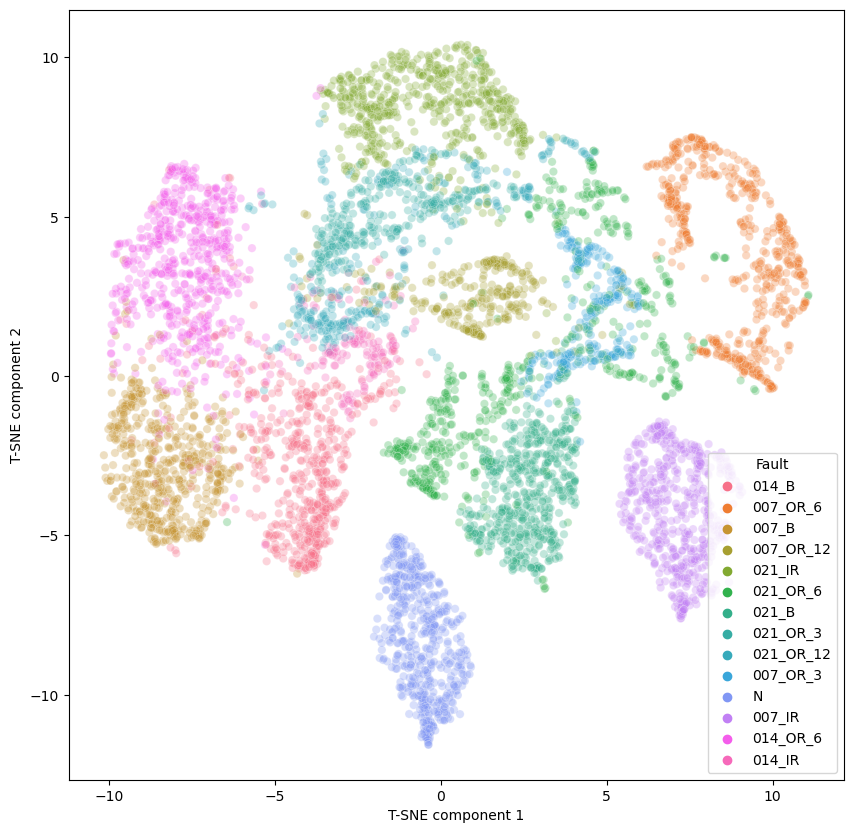

In [13]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)
y_viz = dummy_cnn.predict(X_train)
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [14]:
df = pd.read_csv('1hp_all_faults.csv')

In [15]:
import numpy as np
import pandas as pd
from scipy.signal import cwt, morlet
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len = 784
stride = 300

X = []
Y = []

widths = np.arange(1, 64)
wavelet = morlet

for k in df['fault'].unique():
    df_temp_2 = df[df['fault'] == k]

    for i in np.arange(0, len(df_temp_2) - (win_len), stride):
        temp = df_temp_2.iloc[i:i + win_len, :-1].values
        temp = np.sum(temp, axis=1)
        # Przeprowadź CWT na każdej próbce
        cwt_data = cwt(temp, wavelet, widths)
        
        # Zmień kształt danych (pozostaw dwuwymiarowe)
        cwt_data = np.abs(cwt_data)

        X.append(cwt_data)
        Y.append(df_temp_2.iloc[i + win_len, -1])

X = np.array(X)
Y = np.array(Y)

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

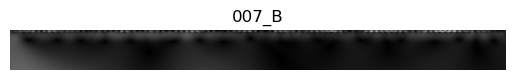

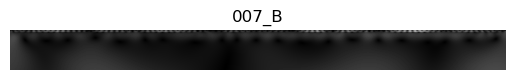

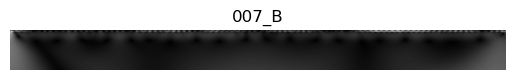

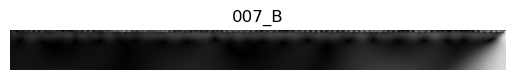

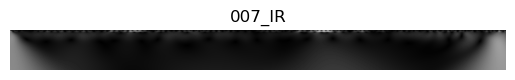

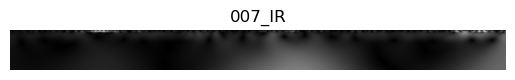

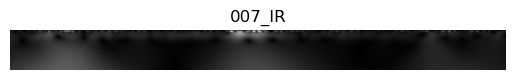

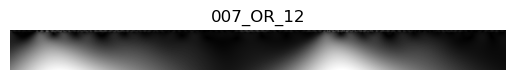

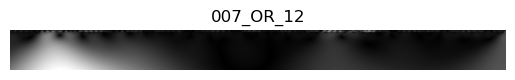

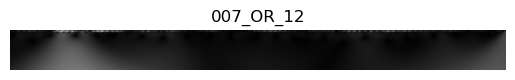

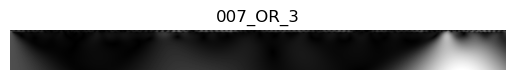

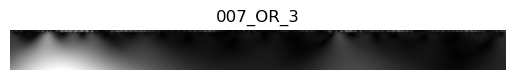

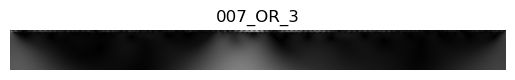

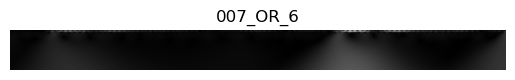

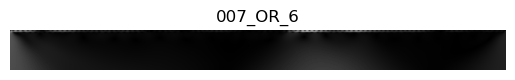

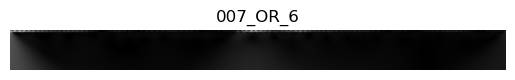

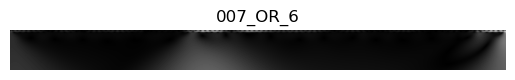

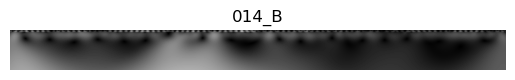

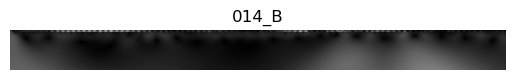

In [16]:
from matplotlib.pyplot import imread


for idx in range(0,9244,500):
    img=X[idx]

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [18]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(6, kernel_size=(5, 5), activation='relu',  input_shape=(X.shape[1],X.shape[2],1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(16, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 59, 780, 6)        156       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 29, 390, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 386, 16)       2416      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 12, 193, 16)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 37056)             0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [20]:
# Definiujesz wczesne zatrzymywanie
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trenujesz model z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodajesz wczesne zatrzymywanie do listy callbacks
)

Epoch 1/80
40/40 [==============================] - 211s 5s/step - loss: 1.7143 - accuracy: 0.4097 - val_loss: 1.1346 - val_accuracy: 0.6007
Epoch 2/80
40/40 [==============================] - 197s 5s/step - loss: 0.8206 - accuracy: 0.7119 - val_loss: 0.6611 - val_accuracy: 0.7413
Epoch 3/80
40/40 [==============================] - 197s 5s/step - loss: 0.5150 - accuracy: 0.8087 - val_loss: 0.6027 - val_accuracy: 0.7671
Epoch 4/80
40/40 [==============================] - 197s 5s/step - loss: 0.4124 - accuracy: 0.8461 - val_loss: 0.4561 - val_accuracy: 0.8282
Epoch 5/80
40/40 [==============================] - 195s 5s/step - loss: 0.3303 - accuracy: 0.8801 - val_loss: 0.3397 - val_accuracy: 0.8720
Epoch 6/80
40/40 [==============================] - 195s 5s/step - loss: 0.2777 - accuracy: 0.8999 - val_loss: 0.3486 - val_accuracy: 0.8667
Epoch 7/80
40/40 [==============================] - 195s 5s/step - loss: 0.2453 - accuracy: 0.9097 - val_loss: 0.2690 - val_accuracy: 0.9054
Epoch 8/80
40

210/210 [==============================] - 22s 104ms/step


Text(95.72222222222221, 0.5, 'Poprawna klasa')

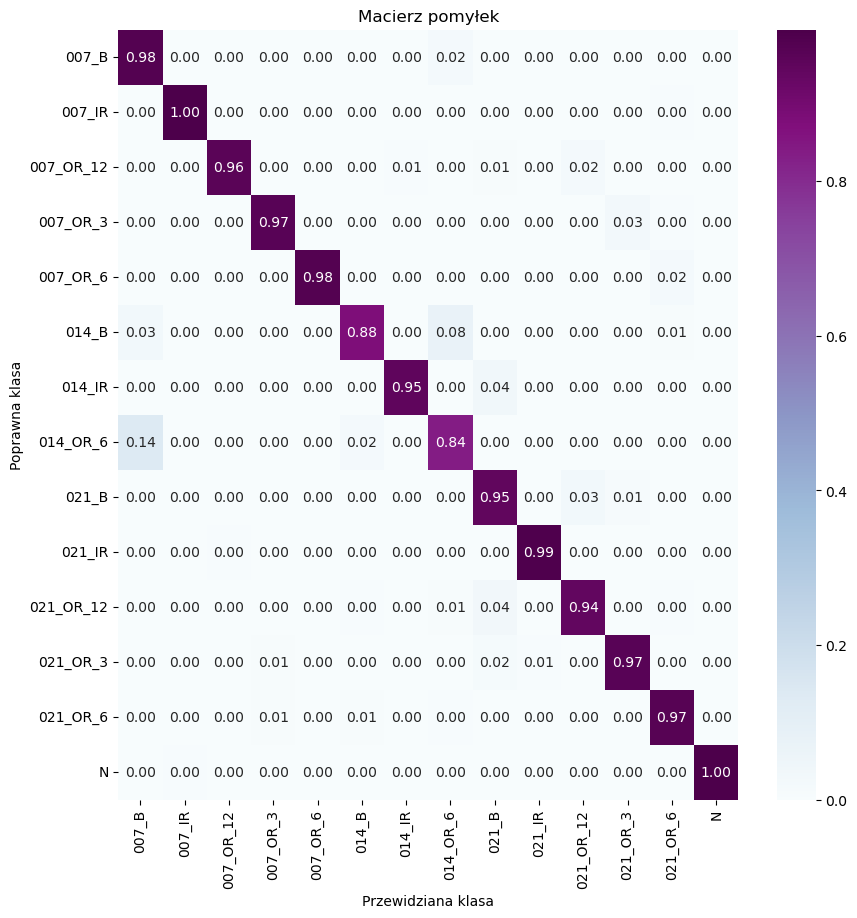

In [21]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

In [22]:
from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, Y_pred)
print(score)

0.9541380340603526


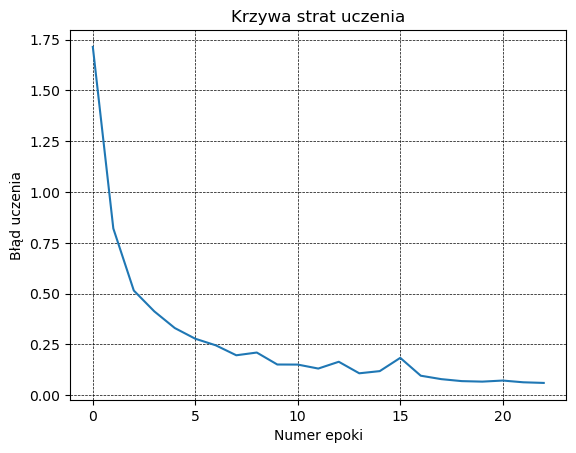

In [23]:
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

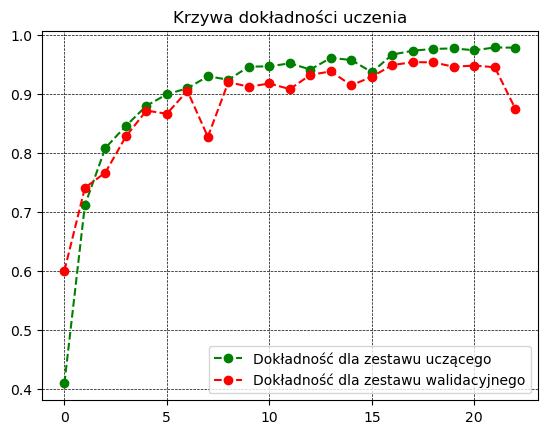

In [24]:
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

489/489 [==============================] - 52s 106ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15617 samples in 0.005s...
[t-SNE] Computed neighbors for 15617 samples in 1.540s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15617
[t-SNE] Computed conditional probabilities for sample 2000 / 15617
[t-SNE] Computed conditional probabilities for sample 3000 / 15617
[t-SNE] Computed conditional probabilities for sample 4000 / 15617
[t-SNE] Computed conditional probabilities for sample 5000 / 15617
[t-SNE] Computed conditional probabilities for sample 6000 / 15617
[t-SNE] Computed conditional probabilities for sample 7000 / 15617
[t-SNE] Computed conditional probabilities for sample 8000 / 15617
[t-SNE] Computed conditional probabilities for sample 9000 / 15617
[t-SNE] Computed conditional probabilities for sample 10000 / 15617
[t-SNE] Computed conditional probabilities for sample 11000 / 15617
[t-SNE] Computed conditional probabilities for sample 12000

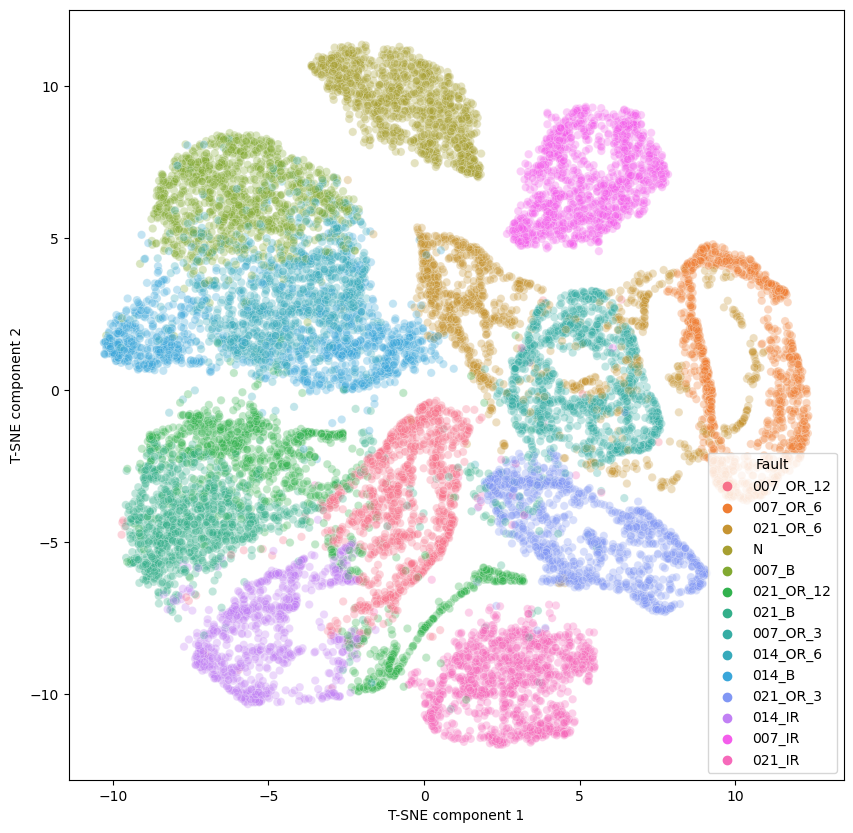

In [25]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)
y_viz = dummy_cnn.predict(X_train)
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [28]:
df = pd.read_csv('2hp_all_faults.csv')

In [30]:
import numpy as np
import pandas as pd
from scipy.signal import cwt, morlet
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len = 784
stride = 300

X = []
Y = []

widths = np.arange(1, 64)
wavelet = morlet

for k in df['fault'].unique():
    df_temp_2 = df[df['fault'] == k]

    for i in np.arange(0, len(df_temp_2) - (win_len), stride):
        temp = df_temp_2.iloc[i:i + win_len, :-1].values
        temp = np.sum(temp, axis=1)
        # Przeprowadź CWT na każdej próbce
        cwt_data = cwt(temp, wavelet, widths)
        
        # Zmień kształt danych (pozostaw dwuwymiarowe)
        cwt_data = np.abs(cwt_data)

        X.append(cwt_data)
        Y.append(df_temp_2.iloc[i + win_len, -1])

X = np.array(X)
Y = np.array(Y)

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

MemoryError: Unable to allocate 8.35 GiB for an array with shape (22692, 63, 784) and data type float64

In [ ]:
from matplotlib.pyplot import imread


for idx in range(0,9244,500):
    img=X[idx]

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [ ]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(X.shape[1],X.shape[2],1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(16, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

In [ ]:
# Definiujesz wczesne zatrzymywanie
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trenujesz model z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodajesz wczesne zatrzymywanie do listy callbacks
)

In [ ]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

In [ ]:
from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, Y_pred)
print(score)

In [ ]:
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

In [ ]:
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)
y_viz = dummy_cnn.predict(X_train)
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [ ]:
df = pd.read_csv('3hp_all_faults.csv')

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import cwt, morlet
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len = 784
stride = 300

X = []
Y = []

widths = np.arange(1, 64)
wavelet = morlet

for k in df['fault'].unique():
    df_temp_2 = df[df['fault'] == k]

    for i in np.arange(0, len(df_temp_2) - (win_len), stride):
        temp = df_temp_2.iloc[i:i + win_len, :-1].values
        temp = np.sum(temp, axis=1)
        # Przeprowadź CWT na każdej próbce
        cwt_data = cwt(temp, wavelet, widths)
        
        # Zmień kształt danych (pozostaw dwuwymiarowe)
        cwt_data = np.abs(cwt_data)

        X.append(cwt_data)
        Y.append(df_temp_2.iloc[i + win_len, -1])

X = np.array(X)
Y = np.array(Y)

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [ ]:
from matplotlib.pyplot import imread


for idx in range(0,9244,500):
    img=X[idx]

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [ ]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(6, kernel_size=(5, 5), activation='relu',  input_shape=(X.shape[1],X.shape[2],1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(16, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

In [ ]:
# Definiujesz wczesne zatrzymywanie
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trenujesz model z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodajesz wczesne zatrzymywanie do listy callbacks
)

In [ ]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

In [ ]:
from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, Y_pred)
print(score)

In [ ]:
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

In [ ]:
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)
y_viz = dummy_cnn.predict(X_train)
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

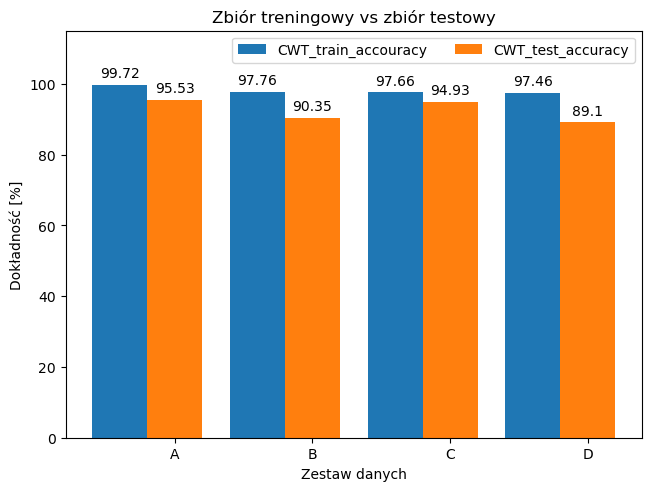

In [33]:
CWT_train_accouracy = [99.72, 97.76, 97.66 , 97.46 ]
CWT_test_accuracy = [95.53, 90.35, 94.93, 89.10 ]

models = ('A', 'B', 'C', 'D')    
CWT_data = {
'CWT_train_accouracy' : (99.72, 97.76, 97.66 , 97.46),
'CWT_test_accuracy' : (95.53, 90.35, 94.93, 89.10),
}


x = np.arange(len(models))
width = 0.4
multiplier = 0
fig, ax = plt.subplots(layout = 'constrained')
for attribute, measurement in CWT_data.items():
    offset = width * multiplier
    rects= ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1
    
ax.set_ylabel('Dokładność [%]')
ax.set_xlabel('Zestaw danych')
ax.set_title('Zbiór treningowy vs zbiór testowy')
ax.set_xticks(x + width, models)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 115)
plt.show()